### Code documentation
- class World: Initializes the data and creates the 100 percentiles
    - rate_ret: Already 100 percentiles (fit the weird exp curve)
    - income/wealth array: Already 100 percentiles (from data)
    - sav_rate: ["90","10","1"]
    - cap_gains: ["90","10","1"] --> This is already (1+q)
    
- class DecileAgent: Updates the wealth based on the rules

- class InequalityModel: Initializes and run the model

### Variables
https://docs.google.com/spreadsheets/d/1WHFQIsf8q8zV_ir-UKZyv2qGMIWEGEZkaIwdJzakf3M/edit#gid=0


### Setup
conda create -n ineq python=3 numpy pandas seaborn matplotlib ipykernel
source activate ineq
pip install mesa

In [141]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import pylab as plt
%matplotlib inline

## Check the possible effect of each paramenter


In [142]:
values = pickle.load(open("data_abm/year2saving.dump","rb"))
init = np.ones(len(values[1966]))

for y in values:

    print(y,values[y])
    if y==2012:
        break
    init *= (1+values[y])

init[[0,-1]]

1966 [0.08106 0.22223 0.30822]
1967 [0.0857  0.31644 0.09706]
1968 [0.03389 0.25243 0.42879]
1969 [-0.00596  0.27736  0.67289]
1970 [0.04485 0.37113 0.25239]
1971 [ 0.07066  0.42249 -0.03106]
1972 [0.07852 0.32711 0.10446]
1973 [0.00974 0.2094  0.68754]
1974 [0.0362  0.28093 0.46603]
1975 [0.08198 0.36357 0.18353]
1976 [0.07078 0.32224 0.40245]
1977 [0.04825 0.30699 0.56611]
1978 [0.04441 0.29584 0.55728]
1979 [0.07002 0.25641 0.38684]
1980 [0.0911  0.20857 0.47744]
1981 [0.10166 0.16478 0.37627]
1982 [0.10769 0.19868 0.36895]
1983 [0.10727 0.23475 0.42618]
1984 [0.09734 0.23374 0.37295]
1985 [0.07571 0.25791 0.49421]
1986 [0.03445 0.23832 0.77856]
1987 [0.0153  0.18334 0.63583]
1988 [0.0216  0.16771 0.35188]
1989 [0.04186 0.18839 0.30281]
1990 [0.05223 0.24481 0.25696]
1991 [0.02985 0.27243 0.35472]
1992 [0.03533 0.24829 0.34911]
1993 [0.03437 0.18231 0.38129]
1994 [0.03656 0.15481 0.26534]
1995 [0.0267  0.14255 0.29378]
1996 [0.01328 0.11009 0.32504]
1997 [0.00038 0.0921  0.32818]
19

array([3.31371004e+00, 1.34007588e+06])

[ 0.02533608 -0.00640041]


(-0.2, 0.5)

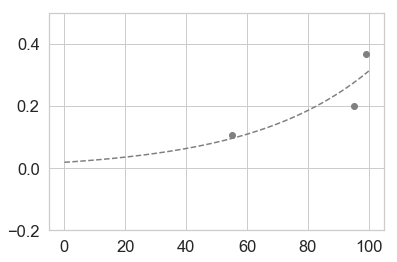

In [143]:
from scipy.optimize import curve_fit

def func(x, a, c):
    return a*np.exp(a*x) + c

values = ([0.10769, 0.19868 ,0.36895])
m_perc = np.array([55,95,99])
popt, pcov = curve_fit(func, m_perc, values)
print(popt)
y = func(np.arange(0,101),*popt)
c = 0.5#cs.pop(0)
plt.plot(m_perc,(values),"o",color=[c,c,c],label=str("year"))
plt.plot(np.arange(0,101),(y),"--",color=[c,c,c],label="")
# plt.yscale("log")
plt.ylim(-0.2,0.5)
#plt.xscale("log")

## Some variables we'll use later

In [144]:
#Read dict
real_wealth = pickle.load(open("data_abm/year2wealth.dump","rb"))
#Convert to dataframe
real_wealth = pd.DataFrame.from_dict(real_wealth,orient="index").reset_index()
#Change name of index
real_wealth = real_wealth.rename(columns={"index":"year"})
#Melt to tidy and merge with results
real_wealth = pd.melt(real_wealth,id_vars=["year"],value_vars=range(100),var_name="perc",value_name="Wealth_real")
real_wealth["perc"] = real_wealth["perc"].astype(int)
#Check head
real_wealth.head()

,year,perc,Wealth_real
0,1966,0,-43216.278118
1,1967,0,-52311.972129
2,1968,0,-39233.631068
3,1969,0,-53205.016042
4,1970,0,-40913.301734


# Model

In [159]:
# world.py

import pickle
class World:
    #Initiates variables for master equation
    def __init__(self, model): 
        self.model = model
        self.rate_ret = self.pickle_open("data_abm/year2rate_return.dump")
        
        self.income_array = self.pickle_open("data_abm/year2income.dump")
        
        self.wealth_array = self.pickle_open("data_abm/year2wealth.dump")
    
#        self.sav_rate = self.pickle_open("data_abm/year2saving.dump")
        self.cap_gains = self.pickle_open("data_abm/year2capital_gains.dump")
    
#         self.sav_rate = self.create_percentiles(self.sav_rate,perc=[90,9,1])
        self.cap_gains = self.create_percentiles(self.cap_gains,perc=[90,9,1])
        
        
        #self.cap_gains = self.interpolate(self.cap_gains,[55,95,99])
        self.sav_rate = self.create_synthetic_rate()
        ##We could fit a smooth function to the savings rate to be able to see how much the savings rates will increase 
        #with UBI
        
        

    def create_synthetic_rate(self):
        sav_rate = dict()
        for year in self.wealth_array:
            if year == 2012:
                break
            
            num = (self.wealth_array[year+1]/self.cap_gains[year] - self.wealth_array[year])
            den = (self.income_array[year] + self.wealth_array[year]*self.rate_ret[year])
            ssr = num/den
            ssr[ssr < -10] = -10
            sav_rate[year] =ssr
#             print(year,np.round(np.percentile(num/den,[0,1,10,50,90,99,100]),2))
#        print(sav_rate[1994])
#        print(sav_rate[1995])
        return sav_rate
            
        
        
    def interpolate(self,dict_values,med_percentile):
        from scipy.optimize import curve_fit

        def func(x, a, c):
            return a*np.exp(a*x) + c
        for year in dict_values:
            values = dict_values[year]
            if any(np.isnan(values)):
                dict_values[year] = [np.NaN]*100
            else:
                m_perc = np.array(med_percentile)
                popt, pcov = curve_fit(func, m_perc, values)
                new_values = func(np.arange(1,101),*popt)
                dict_values[year] =  new_values
        return dict_values
        


    #Reads in data to update varibales for master equation     
    def create_percentiles(self,dict_values,perc):
        """
        Updates dictionary
        """
        for year in dict_values:
            values = dict_values[year]
            new_values = []
            #for each of the groups
            for i,p in enumerate(perc):
                #use that value for all the percentiles
                val = values[i]
                for _ in range(p):
                    new_values.append(val)
                    
            dict_values[year] = new_values
            
        return dict_values
    
    def pickle_open(self, file):         
        with open(file, 'rb') as f:
            data = pickle.load(f)
            
        return data        

In [215]:
# decileagent.py
"""
Created on Thu Jun 21 18:22:09 2018

@author: ymamo
"""

from mesa import Agent
import random 

class DecileAgent(Agent):
    # Initiaite Each Agent
    def __init__(self, unique_id, model, wealth, rank, basic_income=0):
        super().__init__(unique_id, model)
        # initial wealth
        self.wealth = wealth
        self.collected_tax = 0
        # which decile (economic class) agent belongs too
        self.rank = rank
        self.basic_income = basic_income
        
    ############################################################################
    #   AGENT FUNCTIONS WHICH OCCUR EACH STEP
    ##############################################################################
    
    def update(self):
        self.collected_tax = 0
        decile = self.rank//100
        
        #with some probability you die and lose your wealth (it is actually included int eh synthetic saving rate)
#         if np.random.random()<1/80: #80 life expectancy
#             self.wealth = 0
#             return None

        #otherwise you get updated
        rate_return = self.model.world.rate_ret[self.model.time][decile]
        income_yr = self.model.world.income_array[self.model.time][decile]
        cap_gains = self.model.world.cap_gains[self.model.time][decile]
        sav_rate = self.model.world.sav_rate[self.model.time][decile]
        
        #Pay tax on capital only if your returns on wealth are greater than 0
        tax_capital = 0
        if self.wealth*rate_return > 0:
            tax_capital = self.model.tax_capital
        
        #Calcultate income and wealth
        income = (1-self.model.tax_labor)*income_yr + (1-tax_capital)*self.wealth*rate_return
        self.wealth = self.basic_income + (cap_gains) *(self.wealth + sav_rate*income)
        
        #Calculate consumption and vat to pay
        if (income > 0) & (sav_rate < 1):
            consumption = income*(1-sav_rate)
            vat_total = self.model.vat*consumption
        else:
            consumption = income_yr
            vat_total = self.model.vat*income_yr
        
        #Take out the vat
        self.wealth = self.wealth - vat_total
        
        #Add wealth tax
        if self.wealth < 0:
            self.wealth = self.wealth
        else:
            self.wealth = self.wealth*(1-self.model.tax_wealth)
            self.collected_tax += self.wealth*self.model.tax_wealth
       
        #Keep track of collected tax
        self.collected_tax += self.model.tax_labor*income_yr
        self.collected_tax += self.model.tax_capital*self.wealth*rate_return
        self.collected_tax += self.model.tax_labor*income_yr
        self.collected_tax += self.model.vat*consumption
        
        
        '''
        if random.random() < 0.5 : 
           self.income = 1 + self.income
        else: 
           self.income = change_income + 1 + self.income
        '''   
    
    def step(self):
        self.update()
        
        
    
        

In [172]:
# data-inequality
# -*- coding: utf-8 -*-
"""
Created on Thu Jun 21 18:15:05 2018

@author: ymamo
"""
import os
from mesa import Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector


import numpy as np
import pandas as pd


class InequalityModel(Model):
    
    '''
    Model to creat 
    
    '''


    
    def __init__(self,time=1966,tax_labor=0,tax_capital=0,tax_wealth=0,basic_income=0,vat=0):
        ###################################
        #   SET INITIAL NUMBERS
        ###################################
        self.num_agents = 10000
        self.time = time
        #self.wealth_per = np.loadtxt("data_abm/init_wealth_percentile.txt")
        self.wealth_per = pickle.load(open("data_abm/year2wealth.dump","rb"))[time]
        
        self.num_decs = int(self.num_agents/100)
        #self.decile = self.create_deciles(self.wealth_per)
        ###################################
        #   Create Income and Top Down World
        ######################################
        self.schedule = RandomActivation(self)
        self.rank_list = []
        self.world = World(self)
        
        self.tax_labor = tax_labor
        self.tax_capital=tax_capital
        self.tax_wealth=tax_wealth
        self.vat=vat
        
        
        #####################################
        # Create agent and add to schedule
        ########################################
        for i in range(self.num_agents):
            #get correct decile for agent population
            pos = i//100
            #Add some noise to the initial wealth
            wealth = self.wealth_per[pos] + np.random.randn()*np.sqrt(np.abs(self.wealth_per[pos]))
            a = DecileAgent(i, self, wealth,i,basic_income)
            self.schedule.add(a)
            self.rank_list.append(a)
        self.datacollector = DataCollector(agent_reporters = {"Wealth" : "wealth", "Rank":"rank", "Tax":"collected_tax"})
        self.datacollector.collect(self)
    
    def rerank(self):
        self.rank_list.sort(key=lambda x: x.wealth)
        for a in self.rank_list:
            a.rank = self.rank_list.index(a)
    ###########################################################################
    #  STEP FUNCTION --- WHAT OCCURS EACH YEAR
    ###########################################################################
    
    def step(self):
        self.rerank()
        self.schedule.step()
        self.time += 1
        self.datacollector.collect(self)
        



In [173]:
def run_model(start=2000,tax_labor=0.0,tax_capital=0,tax_wealth=0,basic_income=0,vat=0):
    ###############################################################################
    #
    #
    #                         RUN THE MODEL
    #
    ################################################################################
    # Create an instance of the model
    test = InequalityModel(time=start,tax_labor=tax_labor,tax_capital=tax_capital,tax_wealth=tax_wealth,basic_income=basic_income,vat=vat)
    n_rounds = 2012-start
    #Range indicate number of steps
    for i in range(n_rounds):
        print(test.time, end=" : ")
        test.step()

    try:
        os.remove("results/results_{}.csv".format(start))
    except FileNotFoundError:
        pass
    results = test.datacollector.get_agent_vars_dataframe()
    results.to_csv("results/results_{}.csv".format(start))



In [174]:
import pylab as plt
%matplotlib inline


In [223]:
def compare_result(start):
    ## Test results
    res = pd.read_csv("results/results_{}.csv".format(start))
    res["perc"] = (res["Rank"]//100)
    res["year"] = res["Step"]+start
    res = res.groupby(["year","perc"]).mean().reset_index()
    res_g = pd.merge(res,real_wealth)
    res_g.loc[res_g["year"]==start].head()
    

    years = np.sort(res_g["year"].unique())
    plt.figure(figsize=(24,4))
    for i,p in enumerate([1,10,50,90,99]):
        plt.subplot(1,5,i+1)
        plt.plot(years,res_g.loc[res_g["perc"]==p,"Wealth"]/1E4,label="Wealth")
        plt.plot(years,res_g.loc[res_g["perc"]==p,"Wealth_real"]/1E4,label="Wealth real")
        plt.legend()
        plt.ylabel("Wealth (USD thousdans)")
        plt.xlabel("year")
        #plt.ylim(-0.2E7,1E7)
        plt.title(p)
    return res_g

def plot_gini(rvat):
    plt.figure(figsize=(6,4))
    plt.plot(rvat.groupby("year").apply(lambda x: x.loc[x["perc"]>=90,"Wealth"].sum()/x.loc[(x["perc"]<90)&(x["Wealth"]>0),"Wealth"].sum()),label="Simulated")
    plt.plot(rvat.groupby("year").apply(lambda x: x.loc[x["perc"]>=90,"Wealth_real"].sum()/x.loc[(x["perc"]<90)&(x["Wealth_real"]>0),"Wealth_real"].sum()),label="Real")
    plt.ylabel("Ratio wealth \n top 10% / bottom 90%")
    plt.xlabel("year")
    plt.legend()
    plt.tight_layout()

In [108]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

In [109]:
#Using the saving rates from yonatan
#compare_result(1966)

1966 : 1967 : 1968 : 1969 : 1970 : 1971 : 1972 : 1973 : 1974 : 1975 : 1976 : 1977 : 1978 : 1979 : 1980 : 1981 : 1982 : 1983 : 1984 : 1985 : 1986 : 1987 : 1988 : 1989 : 1990 : 1991 : 1992 : 1993 : 1994 : 1995 : 1996 : 1997 : 1998 : 1999 : 2000 : 2001 : 2002 : 2003 : 2004 : 2005 : 2006 : 2007 : 2008 : 2009 : 2010 : 2011 : 

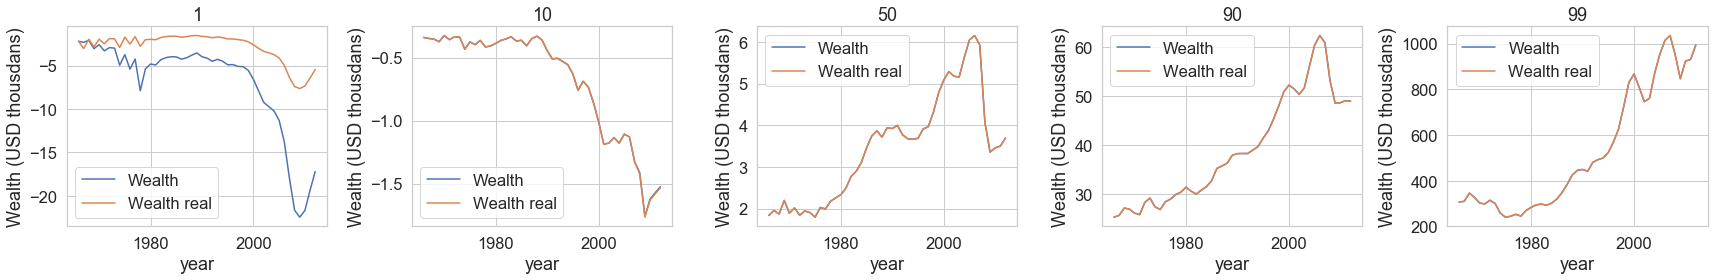

In [176]:
#with new synthetic saving rate
run_model(start=1966,tax_labor=0.0,tax_capital=0,tax_wealth=0)
rbase = compare_result(1966)
plt.tight_layout()
# plt.savefig("./figures/rbase.png",dpi=600)

1966 : 1967 : 1968 : 1969 : 1970 : 1971 : 1972 : 1973 : 1974 : 1975 : 1976 : 1977 : 1978 : 1979 : 1980 : 1981 : 1982 : 1983 : 1984 : 1985 : 1986 : 1987 : 1988 : 1989 : 1990 : 1991 : 1992 : 1993 : 1994 : 1995 : 1996 : 1997 : 1998 : 1999 : 2000 : 2001 : 2002 : 2003 : 2004 : 2005 : 2006 : 2007 : 2008 : 2009 : 2010 : 2011 : 

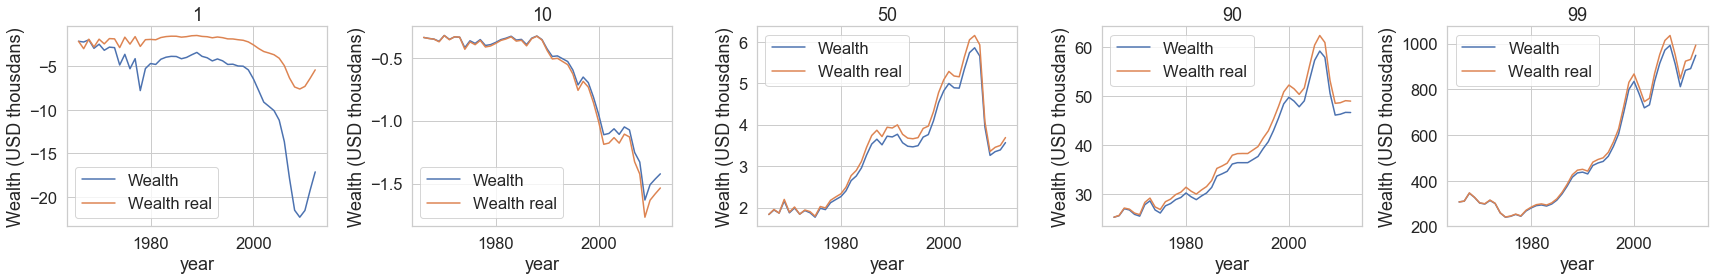

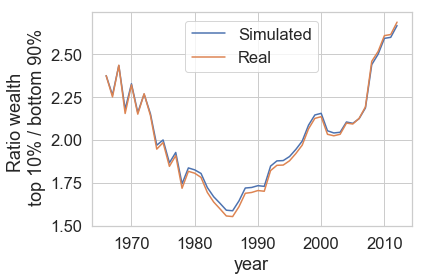

In [187]:
# #with new synthetic saving rate
run_model(start=1966,tax_labor=0.1,tax_capital=0,tax_wealth=0)
rlabor = compare_result(1966)
plt.tight_layout()
#plt.savefig("./figures/rlabor.png",dpi=600)
plot_gini(rlabor)
plt.savefig("./figures/rlabor2.png",dpi=300)

1966 : 1967 : 1968 : 1969 : 1970 : 1971 : 1972 : 1973 : 1974 : 1975 : 1976 : 1977 : 1978 : 1979 : 1980 : 1981 : 1982 : 1983 : 1984 : 1985 : 1986 : 1987 : 1988 : 1989 : 1990 : 1991 : 1992 : 1993 : 1994 : 1995 : 1996 : 1997 : 1998 : 1999 : 2000 : 2001 : 2002 : 2003 : 2004 : 2005 : 2006 : 2007 : 2008 : 2009 : 2010 : 2011 : 

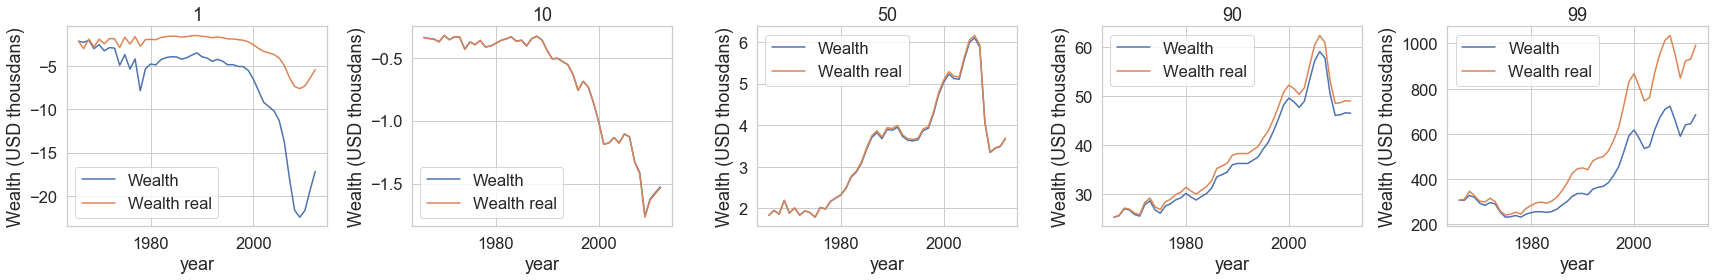

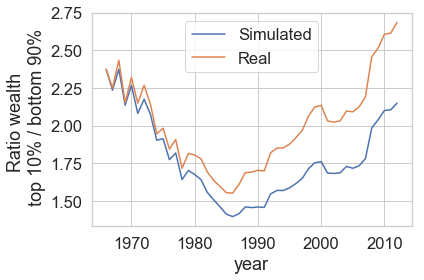

In [189]:
#with new synthetic saving rate
run_model(start=1966,tax_labor=0.0,tax_capital=0.8,tax_wealth=0)
rcapital = compare_result(1966)
plt.tight_layout()
#plt.savefig("./figures/rcapital.png",dpi=600)
plot_gini(rcapital)
plt.savefig("./figures/rcapital2.png",dpi=300)

1966 : 1967 : 1968 : 1969 : 1970 : 1971 : 1972 : 1973 : 1974 : 1975 : 1976 : 1977 : 1978 : 1979 : 1980 : 1981 : 1982 : 1983 : 1984 : 1985 : 1986 : 1987 : 1988 : 1989 : 1990 : 1991 : 1992 : 1993 : 1994 : 1995 : 1996 : 1997 : 1998 : 1999 : 2000 : 2001 : 2002 : 2003 : 2004 : 2005 : 2006 : 2007 : 2008 : 2009 : 2010 : 2011 : 

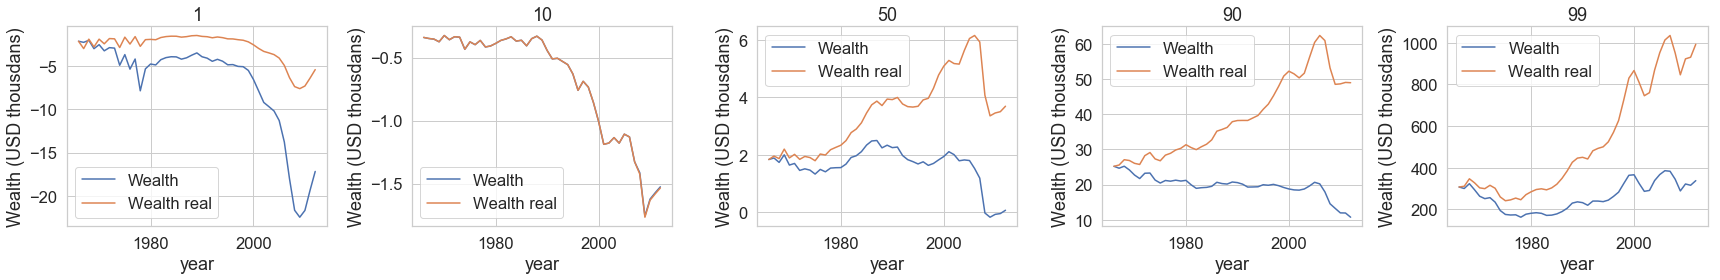

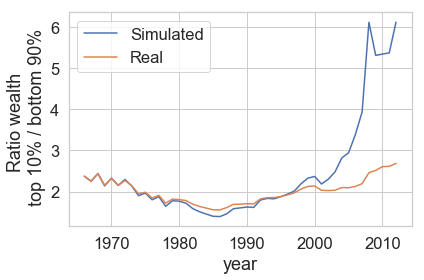

In [190]:
#with new synthetic saving rate
run_model(start=1966,tax_labor=0.0,tax_capital=0.0,tax_wealth=0.03)
rwealth = compare_result(1966)
plt.tight_layout()
#plt.savefig("./figures/rwealth.png",dpi=600)
plt.show()
plot_gini(rwealth)
plt.savefig("./figures/rwealth2.png",dpi=300)

1966 : 1967 : 1968 : 1969 : 1970 : 1971 : 1972 : 1973 : 1974 : 1975 : 1976 : 1977 : 1978 : 1979 : 1980 : 1981 : 1982 : 1983 : 1984 : 1985 : 1986 : 1987 : 1988 : 1989 : 1990 : 1991 : 1992 : 1993 : 1994 : 1995 : 1996 : 1997 : 1998 : 1999 : 2000 : 2001 : 2002 : 2003 : 2004 : 2005 : 2006 : 2007 : 2008 : 2009 : 2010 : 2011 : 

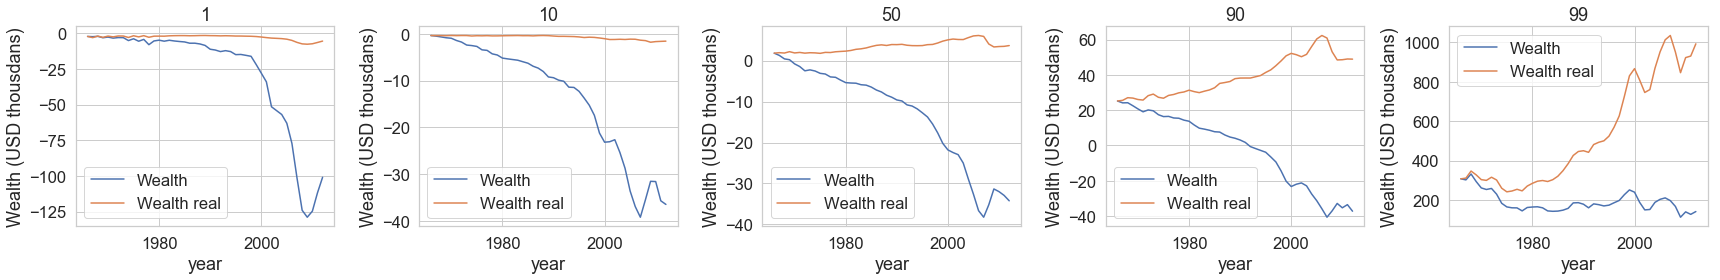

/home/javiergb/Programs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in double_scalars


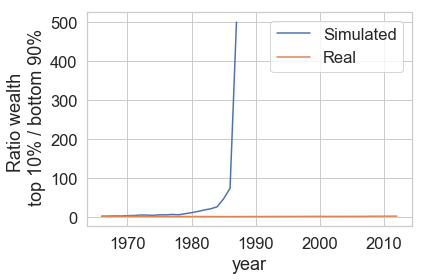

In [191]:
#with new synthetic saving rate
run_model(start=1966,tax_labor=0.0,tax_capital=0.0,tax_wealth=0,vat=0.2)
rvat = compare_result(1966)
plt.tight_layout()
#plt.savefig("./figures/rwealth.png",dpi=600)
plot_gini(rvat)

In [192]:
needed = 12000*len(rbase)
print(needed/1E9)

0.0564


1966 : 1967 : 1968 : 1969 : 1970 : 1971 : 1972 : 1973 : 1974 : 1975 : 1976 : 1977 : 1978 : 1979 : 1980 : 1981 : 1982 : 1983 : 1984 : 1985 : 1986 : 1987 : 1988 : 1989 : 1990 : 1991 : 1992 : 1993 : 1994 : 1995 : 1996 : 1997 : 1998 : 1999 : 2000 : 2001 : 2002 : 2003 : 2004 : 2005 : 2006 : 2007 : 2008 : 2009 : 2010 : 2011 : 1966 : 1967 : 1968 : 1969 : 1970 : 1971 : 1972 : 1973 : 1974 : 1975 : 1976 : 1977 : 1978 : 1979 : 1980 : 1981 : 1982 : 1983 : 1984 : 1985 : 1986 : 1987 : 1988 : 1989 : 1990 : 1991 : 1992 : 1993 : 1994 : 1995 : 1996 : 1997 : 1998 : 1999 : 2000 : 2001 : 2002 : 2003 : 2004 : 2005 : 2006 : 2007 : 2008 : 2009 : 2010 : 2011 : 1966 : 1967 : 1968 : 1969 : 1970 : 1971 : 1972 : 1973 : 1974 : 1975 : 1976 : 1977 : 1978 : 1979 : 1980 : 1981 : 1982 : 1983 : 1984 : 1985 : 1986 : 1987 : 1988 : 1989 : 1990 : 1991 : 1992 : 1993 : 1994 : 1995 : 1996 : 1997 : 1998 : 1999 : 2000 : 2001 : 2002 : 2003 : 2004 : 2005 : 2006 : 2007 : 2008 : 2009 : 2010 : 2011 : 1966 : 1967 : 1968 : 1969 : 1970 :

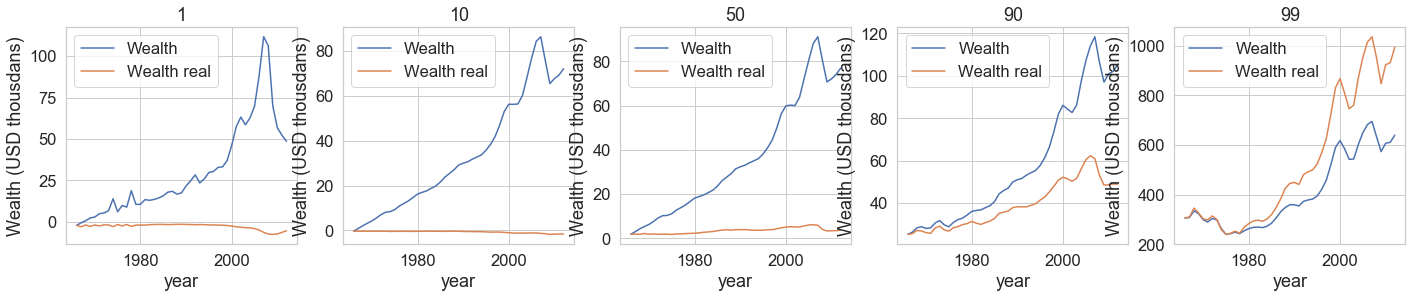

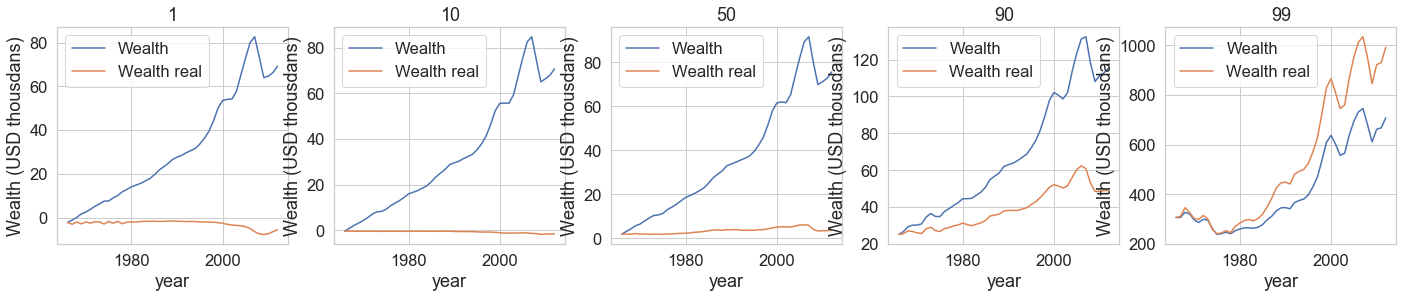

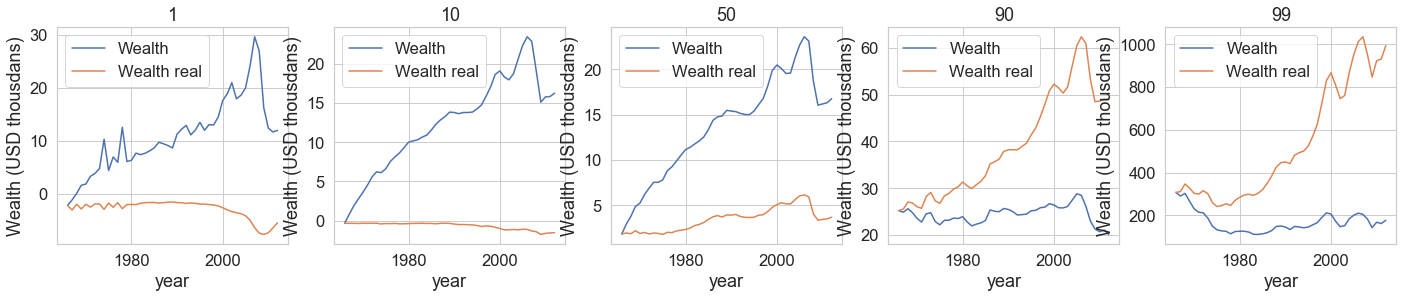

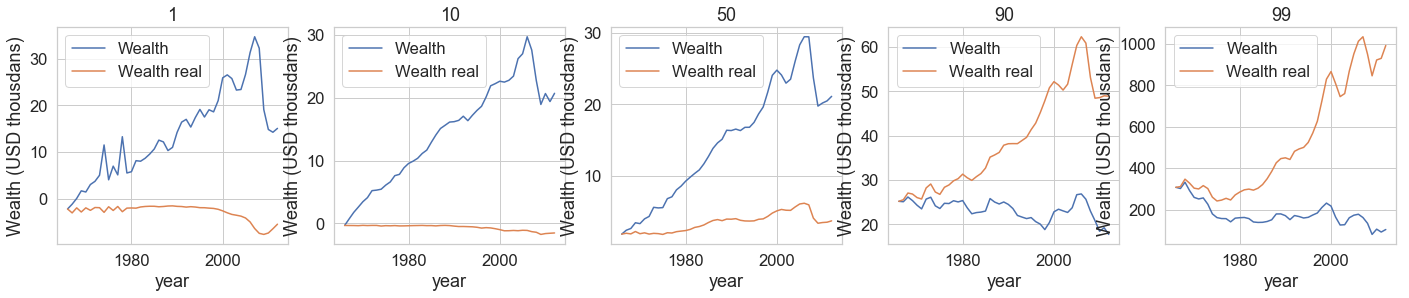

In [222]:
run_model(start=1966,tax_labor=1,tax_capital=0,tax_wealth=0,basic_income=12000)
rlabor_bi = compare_result(1966)
run_model(start=1966,tax_labor=0.0,tax_capital=1,tax_wealth=0,basic_income=12000)
rcapital_bi = compare_result(1966)
run_model(start=1966,tax_labor=0.0,tax_capital=0.0,tax_wealth=0.072,basic_income=12000)
rwealth_bi = compare_result(1966)
run_model(start=1966,tax_labor=0.0,tax_capital=0.0,tax_wealth=0,vat=0.37,basic_income=12000)
rvat_bi = compare_result(1966)

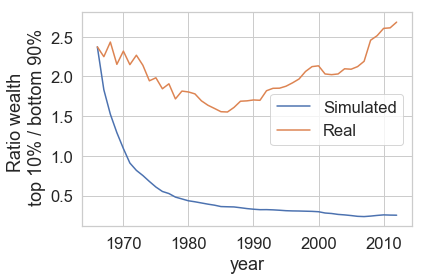

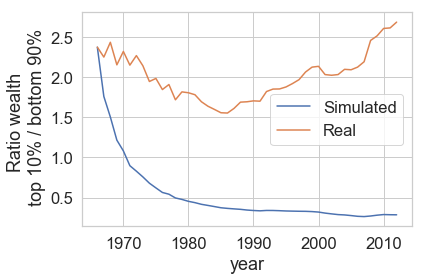

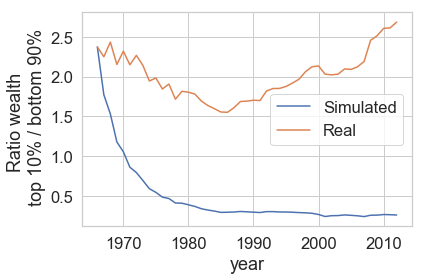

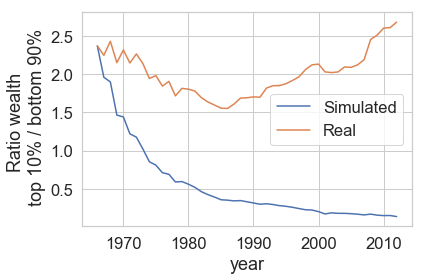

In [224]:
plot_gini(rlabor_bi)
plot_gini(rcapital_bi)
plot_gini(rwealth_bi)
plot_gini(rvat_bi)


In [219]:
print("{:2.4f} {:2.4f} {:2.4f} {:2.4f}".format(rlabor_bi["Tax"].sum()/1E9,rcapital_bi["Tax"].sum()/1E9,rwealth_bi["Tax"].sum()/1E9,rvat_bi["Tax"].sum()/1E9))

0.2537 0.0520 0.0575 0.0678


In [238]:
rbase["Wealth"].sum()/1E9,rlabor_bi["Wealth"].sum()/1E9,rcapital_bi["Wealth"].sum()/1E9,rwealth_bi["Wealth"].sum()/1E9,rvat_bi["Wealth"].sum()/1E9

(0.8061123175469462,
 2.152079005172521,
 2.2802381957142344,
 0.8315910089196942,
 0.8660987753442367)

In [242]:
rlabor_bi["Wealth"].sum()/1E9

2.4028727450976906

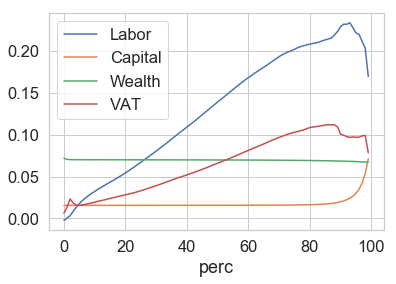

In [236]:
labels = ["Labor","Capital","Wealth","VAT"]
for a in [rlabor_bi,rcapital_bi,rwealth_bi,rvat_bi]:
    a = a.groupby("perc").sum()
    (a["Tax"]/a["Wealth"]).plot(label=labels.pop(0))
    
plt.legend()

## Fixed
- Init is not more similar to reality
- Capital gains was already (1+q). It was duplicating the wealth every turn and that's why wealth was exploding. It doesn't anymore